<a href="https://colab.research.google.com/github/dlai211/Emulsion-IFT-Matching/blob/main/MC_200003(neutrino)_v4_(organized).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install uproot awkward mpl_scatter_density jupyter-dash
import uproot, scipy, math, os, random, time, pickle, collections
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import awkward as ak
from tqdm import tqdm
import pandas as pd
from scipy import stats
from scipy.spatial.distance import cdist
from google.colab import drive
drive.mount('/content/drive')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 331.4/331.4 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 602.7/602.7 kB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 655.5/655.5 kB 35.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 28.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 53.4 MB/s eta 0:00:00
Mounted at /content/drive


# Import Data

In [ ]:
emutxt = pd.read_csv("/content/drive/MyDrive/ForAli/chk_trks_genie_200003_s0007_10files_p761-770.txt", sep='\s+', header=None)
emutxt.columns = ["t->ID", "plate_first", "plate_last", "x1", "y1", "z1", "x", "y", "z", 
               'tx1', 'ty1', "txlast", "tylast", "tx", "ty", "t->N()", "t->Npl()", "eventID", "pdgID", "momentum"]
emutxt = emutxt[emutxt["plate_last"] > 768] # save last two layers
emutxt.eventID = emutxt.eventID - 100000
emutxt

FileNotFoundError: ignored

In [ ]:
# Convert global coordinate

pl = np.array(emutxt['plate_last'])
z_tmp = np.where(pl == 770, -1950.27, np.where(pl == 769, -1951.63, np.nan))


emu = pd.DataFrame({
    'x': emutxt.x/1000 + 10, # convert um to mm and to global coordinate
    'y': emutxt.y/1000 - 21,
    'z': z_tmp,
    'tx': emutxt.tx,
    'ty': emutxt.ty,
    'eventID': emutxt.eventID,
    'pdgID': emutxt.pdgID
})
emu

,x,y,z,tx,ty,eventID,pdgID
0,-56.0304,74.0652,-1950.27,0.011267,-0.033248,2005,211
1,-47.8084,61.0414,-1950.27,0.119072,-0.189240,2005,211
2,-54.2086,79.3274,-1950.27,0.029829,0.023550,2005,-321
3,5.8123,-100.8756,-1950.27,0.003143,0.019987,2019,-211
4,7.7087,-97.6927,-1950.27,0.025531,0.044315,2019,-211
...,...,...,...,...,...,...,...
3410,-47.6098,112.6859,-1950.27,-0.012888,0.003625,8520,-11
3411,54.7122,-0.6966,-1950.27,0.005033,0.000370,20603,-11
3412,89.7099,64.1518,-1951.63,0.006344,0.011868,17718,11
3413,-113.3223,-142.0775,-1950.27,0.007602,0.006833,21259,11


In [ ]:
f = uproot.open('/content/drive/MyDrive/data/Collision/mc_ke_neutrinoMC.root')
f['tree'].show()

ift = f['tree'].arrays(['run_number',
                      'event_number',
                      'truthPdg',
                      'pTruthLepton',
                      'truthBarcode',
                      'ntruthmatchedclus',
                      'chi2',
                      'nclus0',
                      'nclus1',
                      'nclus2',
                      'nclus3',
                      'nclus',
                      'nsta',
                      'firstclus_x',
                      'firstclus_y',
                      'firstclus_z',
                      'lastclus_z',
                      'x',
                      'y',
                      'z',
                      'px',
                      'py',
                      'pz',
                      'p'], library='ak')

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
run_number           | int32_t                  | AsDtype('>i4')
event_number         | int32_t                  | AsDtype('>i4')
VetoNuPmt0           | double                   | AsDtype('>f8')
VetoNuPmt1           | double                   | AsDtype('>f8')
VetoPmt00            | double                   | AsDtype('>f8')
VetoPmt01            | double                   | AsDtype('>f8')
VetoUpstream         | double                   | AsDtype('>f8')
VetoPmt10            | double                   | AsDtype('>f8')
VetoPmt11            | double                   | AsDtype('>f8')
VetoDownstream       | double                   | AsDtype('>f8')
sta0nclus            | int32_t                  | AsDtype('>i4')
sta1nclus            | int32_t                  | AsDtype('>i4')
sta2nclus            | int32_t                  | AsDtype(

## Track Selection

In [ ]:
track_loc = ak.where((ak.flatten(ift['chi2'])<30) & (ak.flatten(ift['z'])<-1875))
track_loc

(<Array [6, 14, 20, 23, 28, ..., 4734, 4737, 4740, 4743] type='920 * int64'>,)

In [ ]:
# record event ID to check if a minimum chi2 track is truth matched
evt_tmp = []
num = ak.num(ift['z'])
for i in tqdm(range(len(ift['event_number']))):
    evt_tmp.append(list(ift['event_number'][i] * np.ones(num[i])))

ift_evt = ak.flatten(ak.Array(evt_tmp))[track_loc]

100%|██████████| 32000/32000 [00:03<00:00, 8211.57it/s]


In [ ]:
iftx = ak.flatten(ift['x'])[track_loc]
ifty = ak.flatten(ift['y'])[track_loc]
iftz = ak.flatten(ift['z'])[track_loc]
ifttx = ak.flatten(ift['px'])[track_loc]/ak.flatten(ift['pz'])[track_loc]
iftty = ak.flatten(ift['py'])[track_loc]/ak.flatten(ift['pz'])[track_loc]

# Z position of module 4 and 6, which is largest z position in IFT 1st layer
module4_z = -1886.1353 # mm
def emu2ift(x, y, z, tx, ty):
    Dist_tot = np.abs(z - module4_z)
    x_pred = Dist_tot * tx + x
    y_pred = Dist_tot * ty + y
    return x_pred, y_pred

emu['x_pred'], emu['y_pred'] = emu2ift(emu['x'], emu['y'], emu['z'], emu['tx'], emu['ty'])

def ift2ift(x, y, z, tx, ty):
    Dist_tot = np.abs(z - module4_z)
    x_pred = Dist_tot * tx + x
    y_pred = Dist_tot * ty + y
    return x_pred, y_pred

ift_x_pred, ift_y_pred = ift2ift(iftx, ifty, iftz, ifttx, iftty)

'''
iftx_pred = iftx + (ak.flatten(ift['z'])[track_loc]+1898.05)*-ifttx
ifty_pred = ifty + (ak.flatten(ift['z'])[track_loc]+1898.05)*-iftty
emu['x_pred'] = emu.x + (-1898.05-emu.z+12.5)*emu.tx
emu['y_pred'] = emu.y + (-1898.05-emu.z+12.5)*emu.ty
'''

"\niftx_pred = iftx + (ak.flatten(ift['z'])[track_loc]+1898.05)*-ifttx\nifty_pred = ifty + (ak.flatten(ift['z'])[track_loc]+1898.05)*-iftty\nemu['x_pred'] = emu.x + (-1898.05-emu.z+12.5)*emu.tx\nemu['y_pred'] = emu.y + (-1898.05-emu.z+12.5)*emu.ty\n"

In [ ]:
emu

,x,y,z,tx,ty,eventID,pdgID,x_pred,y_pred
0,-56.0304,74.0652,-1950.27,0.011267,-0.033248,2005,211,-55.307794,71.932849
1,-47.8084,61.0414,-1950.27,0.119072,-0.189240,2005,211,-40.171753,48.904549
2,-54.2086,79.3274,-1950.27,0.029829,0.023550,2005,-321,-52.295526,80.837772
3,5.8123,-100.8756,-1950.27,0.003143,0.019987,2019,-211,6.013875,-99.593740
4,7.7087,-97.6927,-1950.27,0.025531,0.044315,2019,-211,9.346123,-94.850571
...,...,...,...,...,...,...,...,...,...
3410,-47.6098,112.6859,-1950.27,-0.012888,0.003625,8520,-11,-48.436368,112.918388
3411,54.7122,-0.6966,-1950.27,0.005033,0.000370,20603,-11,55.034990,-0.672870
3412,89.7099,64.1518,-1951.63,0.006344,0.011868,17718,11,90.125398,64.929091
3413,-113.3223,-142.0775,-1950.27,0.007602,0.006833,21259,11,-112.834748,-141.639268


# All Combinatorial Residual Search

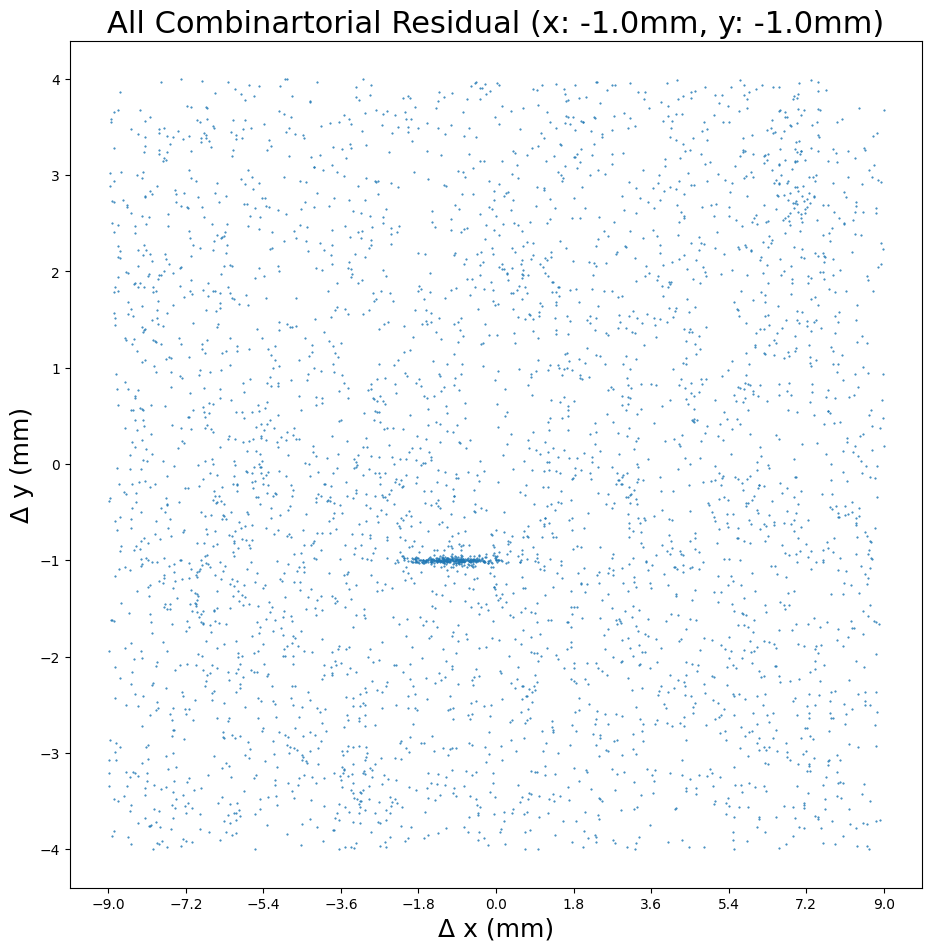

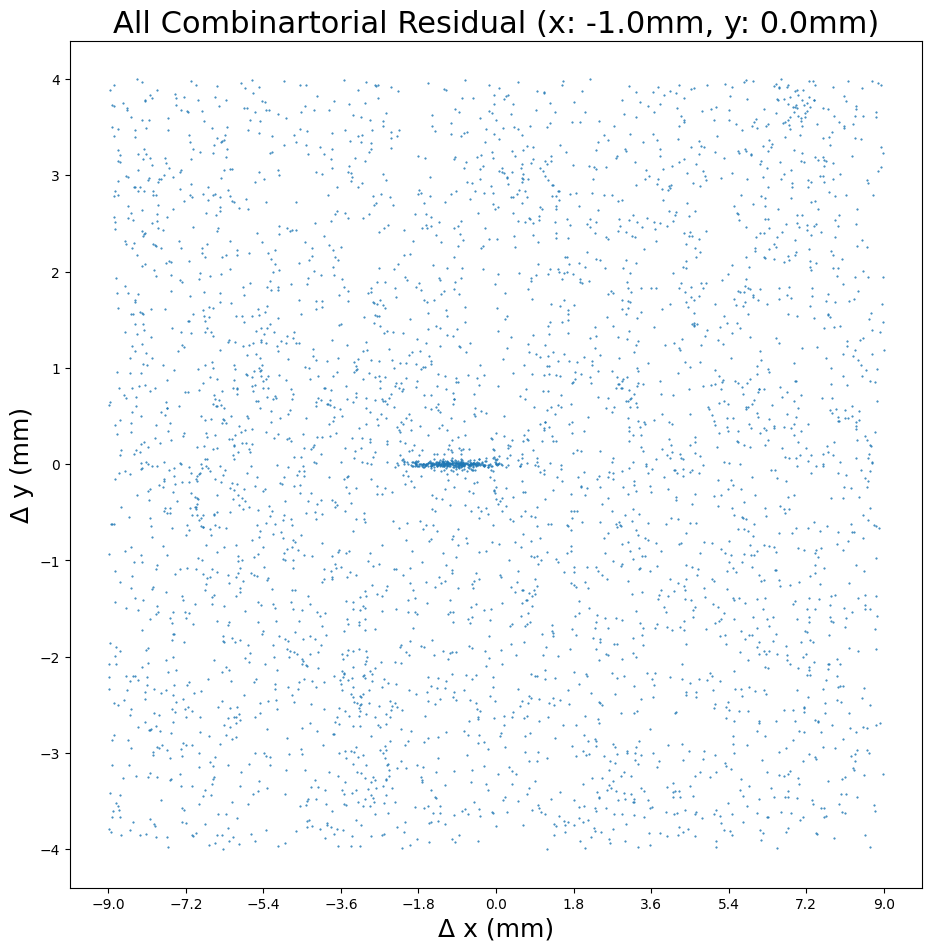

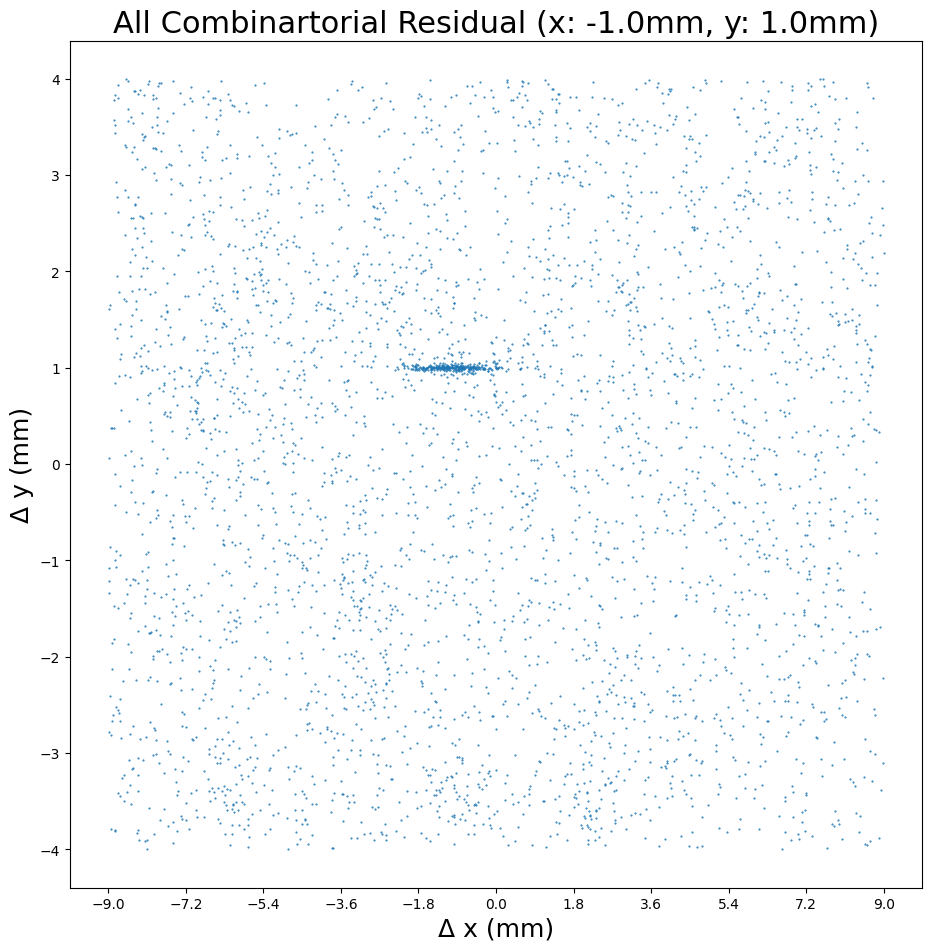

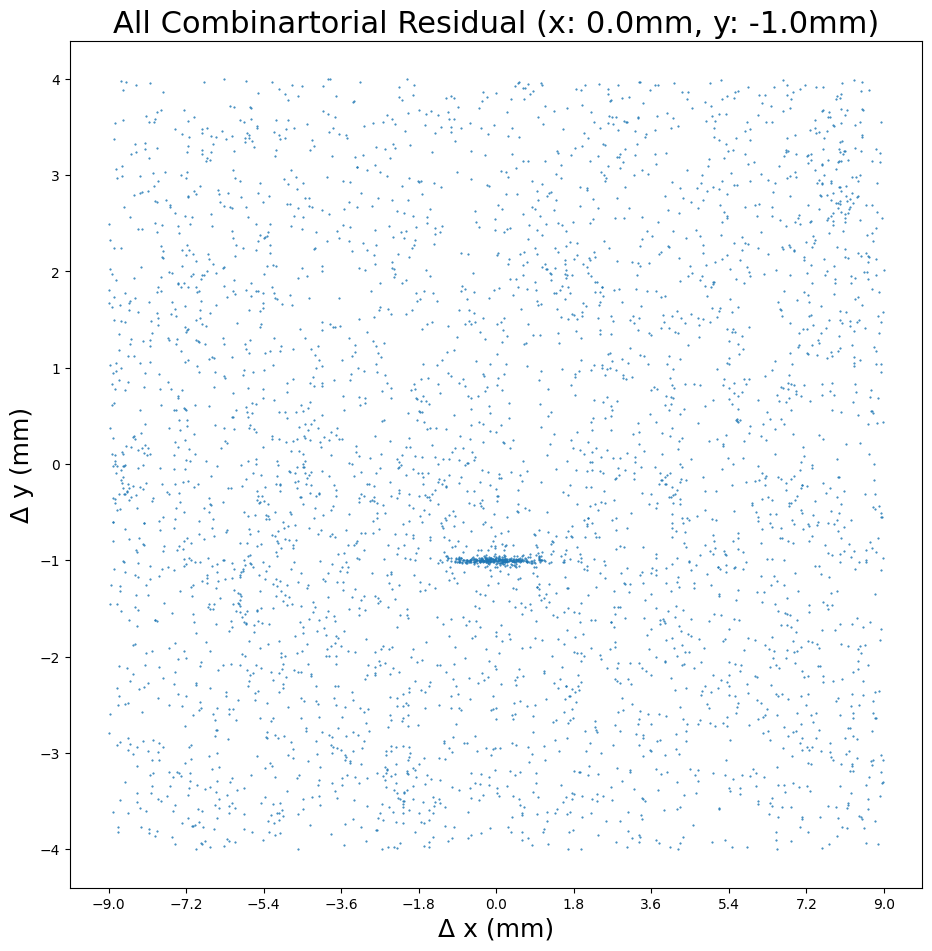

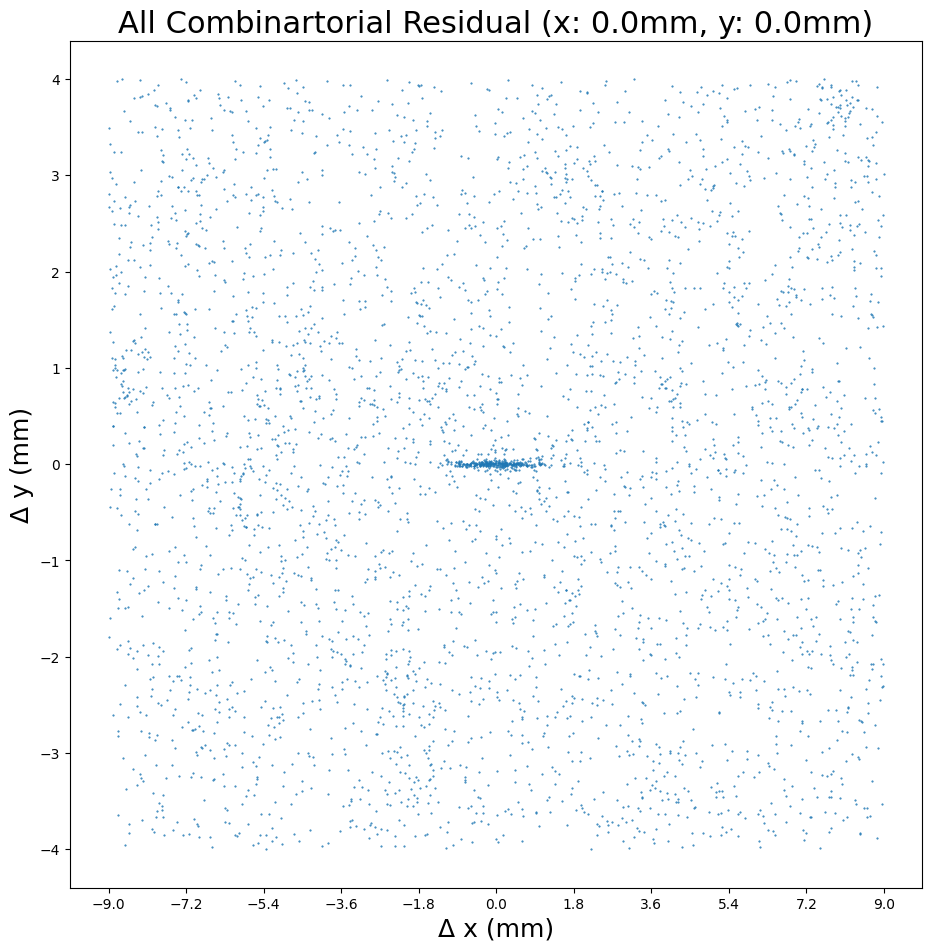

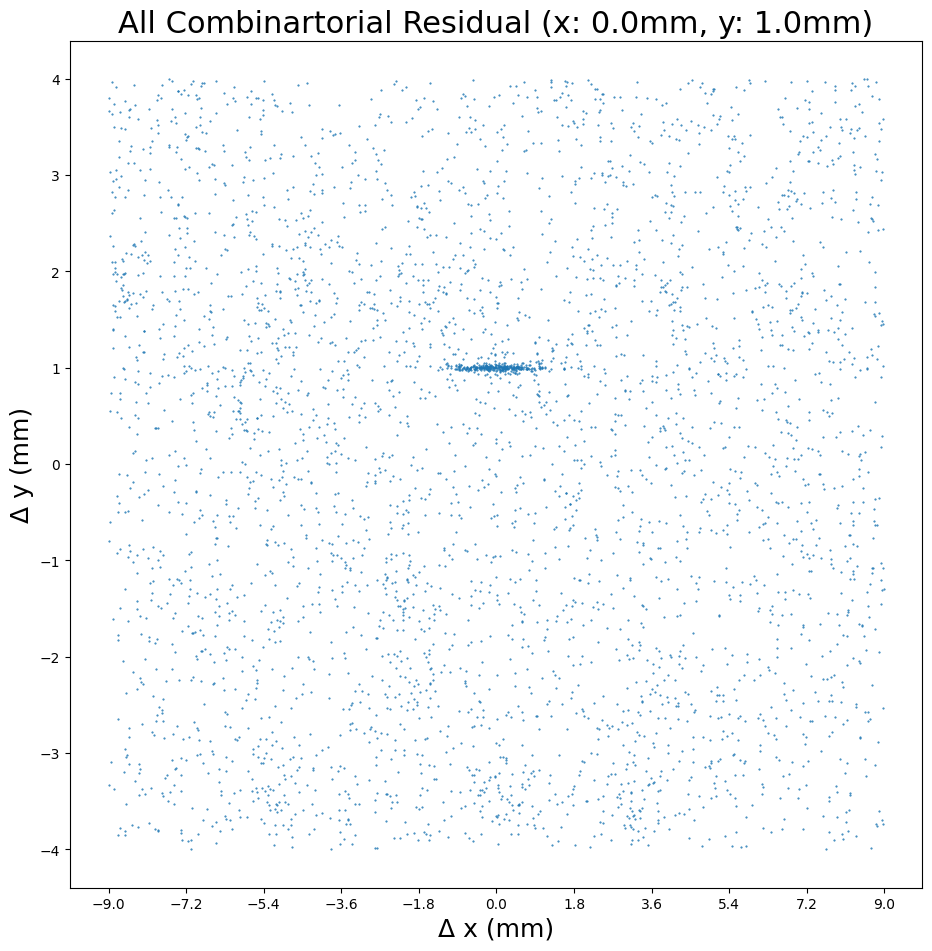

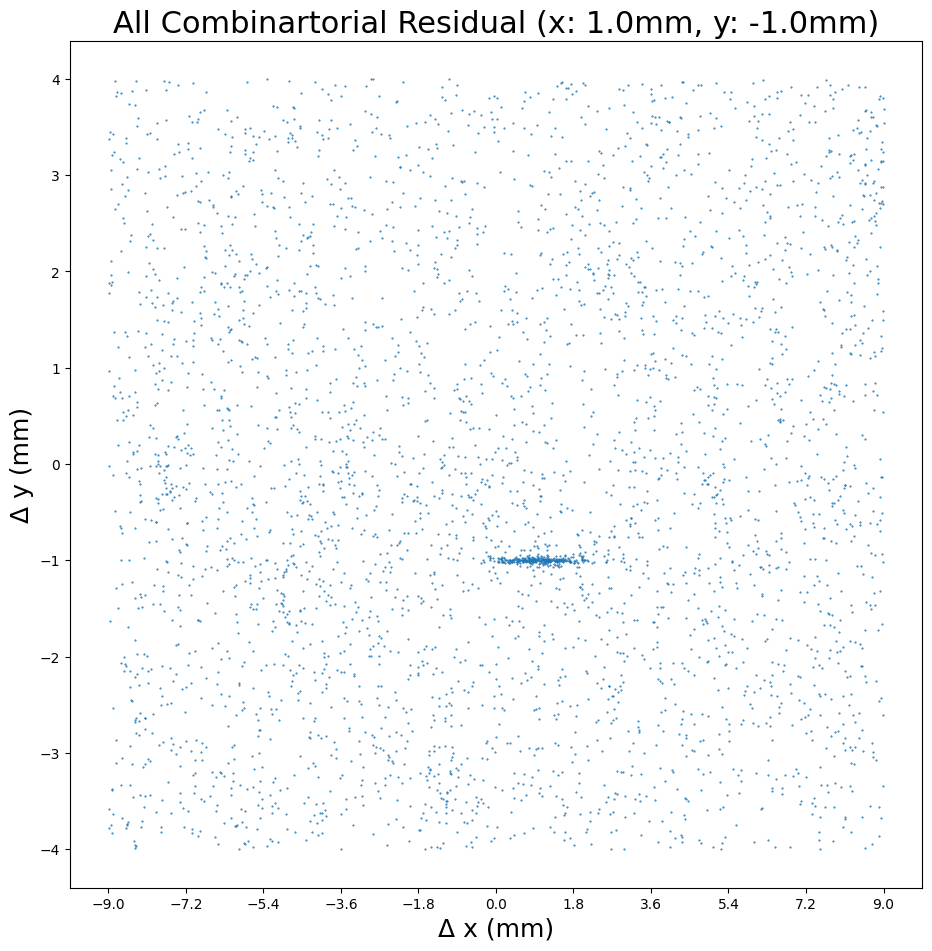

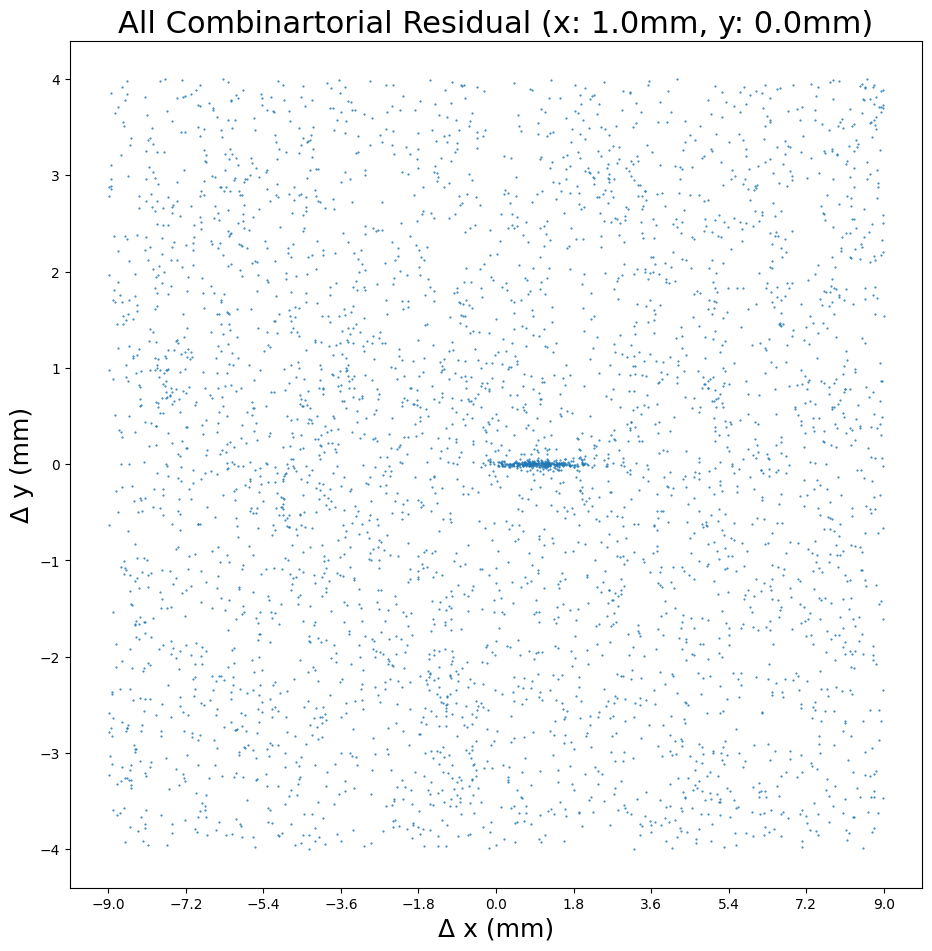

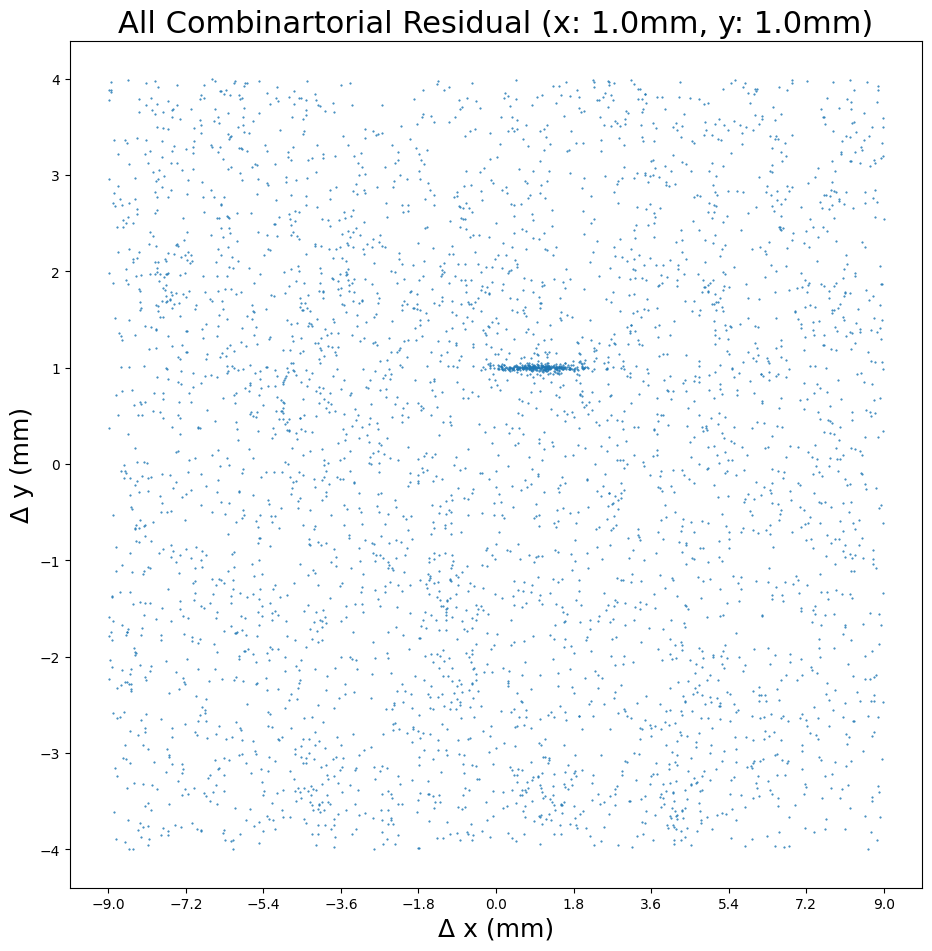

In [ ]:
# Scatter Plot
dx, dy = np.linspace(-1, 1, 3), np.linspace(-1, 1, 3)
for i in range(len(dx)):
    for j in range(len(dy)):
        dy_tmp = ((np.array(ift_y_pred) + dy[j]).reshape(len(ift_x_pred), 1) - np.array(emu.y_pred)).flatten()
        dx_tmp = ((np.array(ift_x_pred) + dx[i]).reshape(len(ift_x_pred), 1) - np.array(emu.x_pred)).flatten()
        dtx_tmp = ((np.array(ifttx)).reshape(len(ift_x_pred), 1) - np.array(emu['tx'])).flatten()
        dty_tmp = ((np.array(iftty)).reshape(len(ift_x_pred), 1) - np.array(emu['ty'])).flatten()
        
        m = pd.DataFrame({'x_res': dx_tmp, 'y_res': dy_tmp, 'tx_res': dtx_tmp, 'ty_res': dty_tmp})
        m = m[(abs(m['x_res']) < 9) & (abs(m['y_res']) < 4) & (abs(m['ty_res']) < 0.1)]

        plt.figure(figsize=(11, 11)) 

        dy_sel = m['y_res']
        dx_sel = m['x_res']
        plt.scatter(dx_sel, dy_sel, marker='.', s=1)
        plt.xlabel(f'Δ x (mm)', fontsize=18)
        plt.ylabel(f'Δ y (mm)', fontsize=18)
        plt.title(f'All Combinartorial Residual (x: {round(dx[i], 2)}mm, y: {round(dy[j], 2)}mm)', fontsize=22)
        plt.xticks(np.linspace(-9, 9, 11), fontsize=10)
        #plt.yticks(np.linspace(-.2, .2, 11), fontsize=10)
        #plt.legend(fontsize=15)

        plt.show()

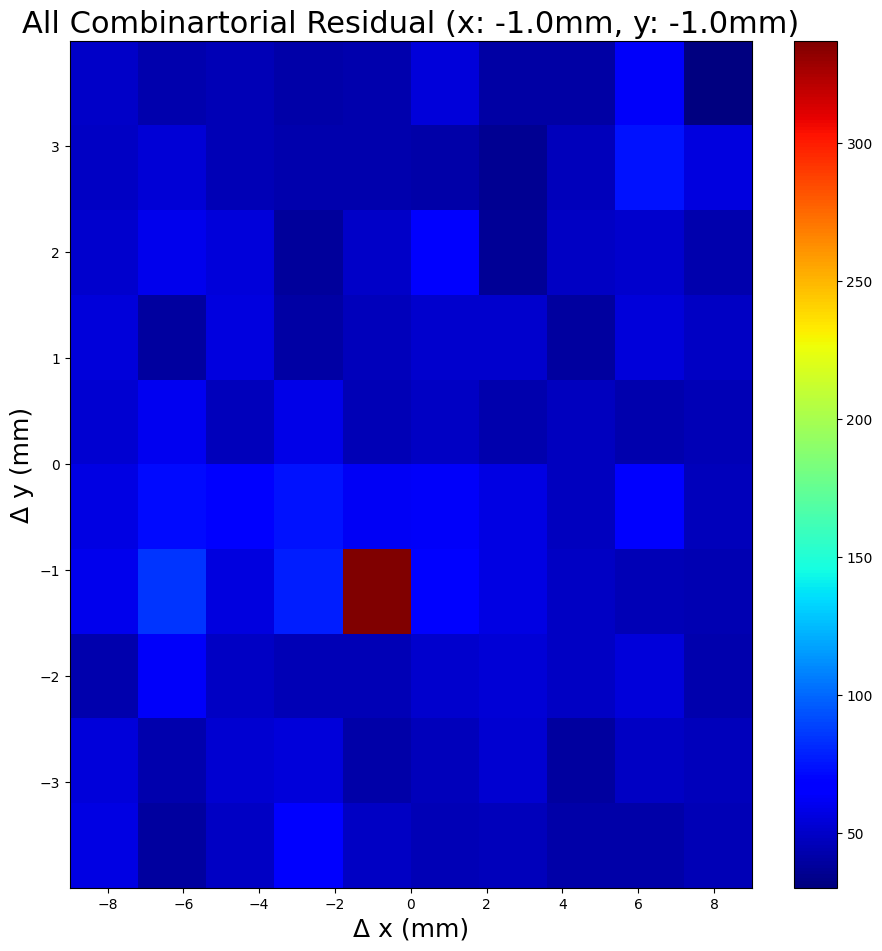

<Figure size 640x480 with 0 Axes>

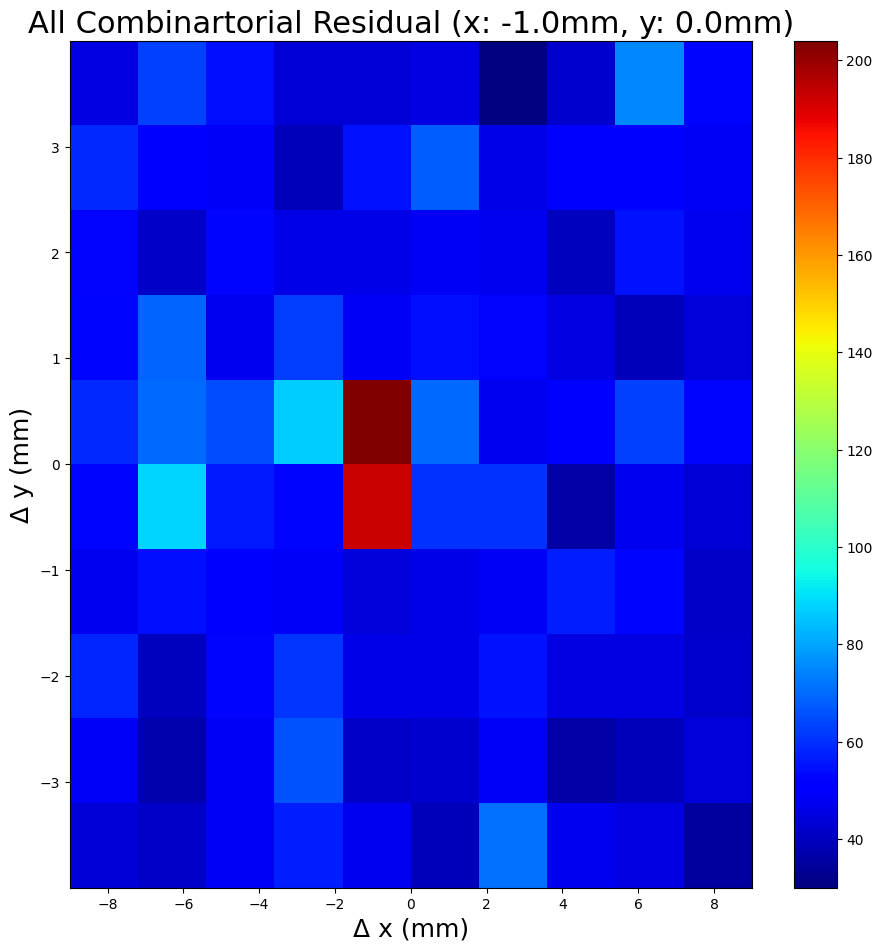

<Figure size 640x480 with 0 Axes>

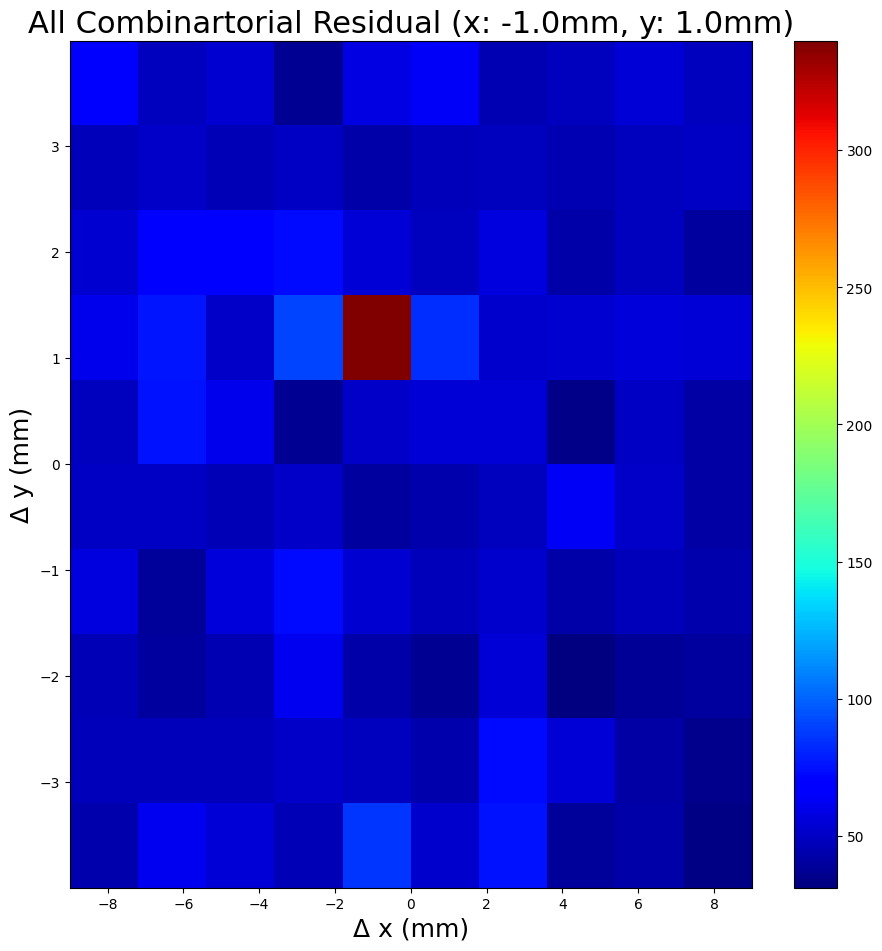

<Figure size 640x480 with 0 Axes>

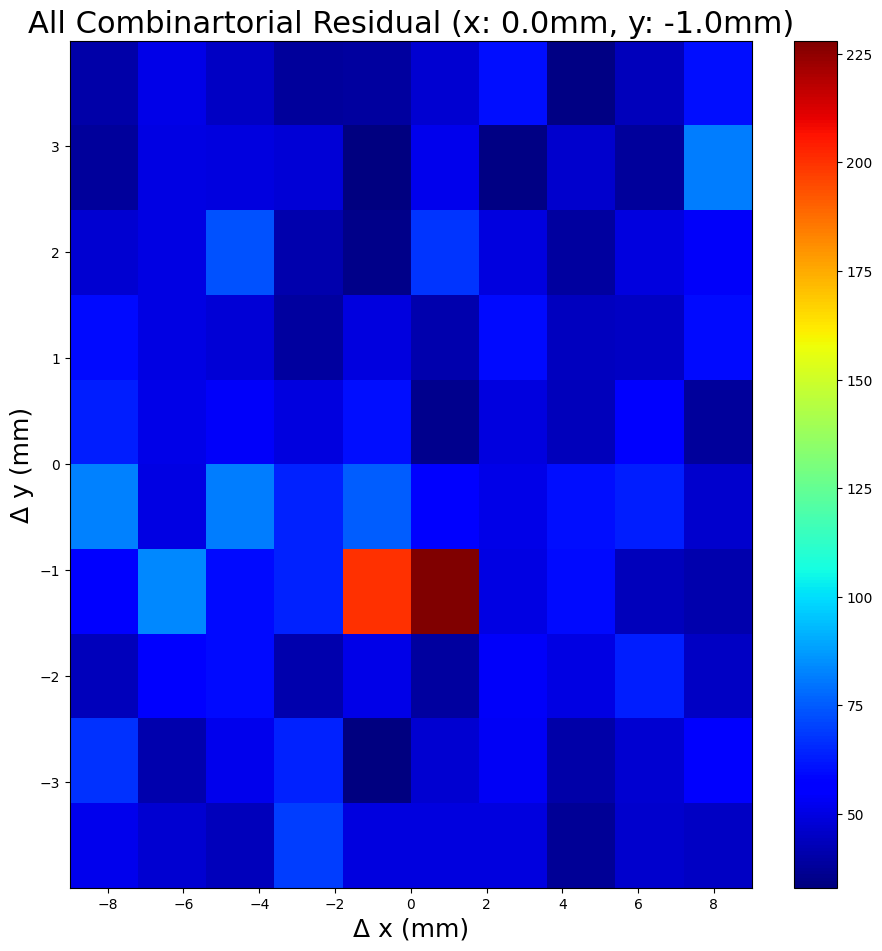

<Figure size 640x480 with 0 Axes>

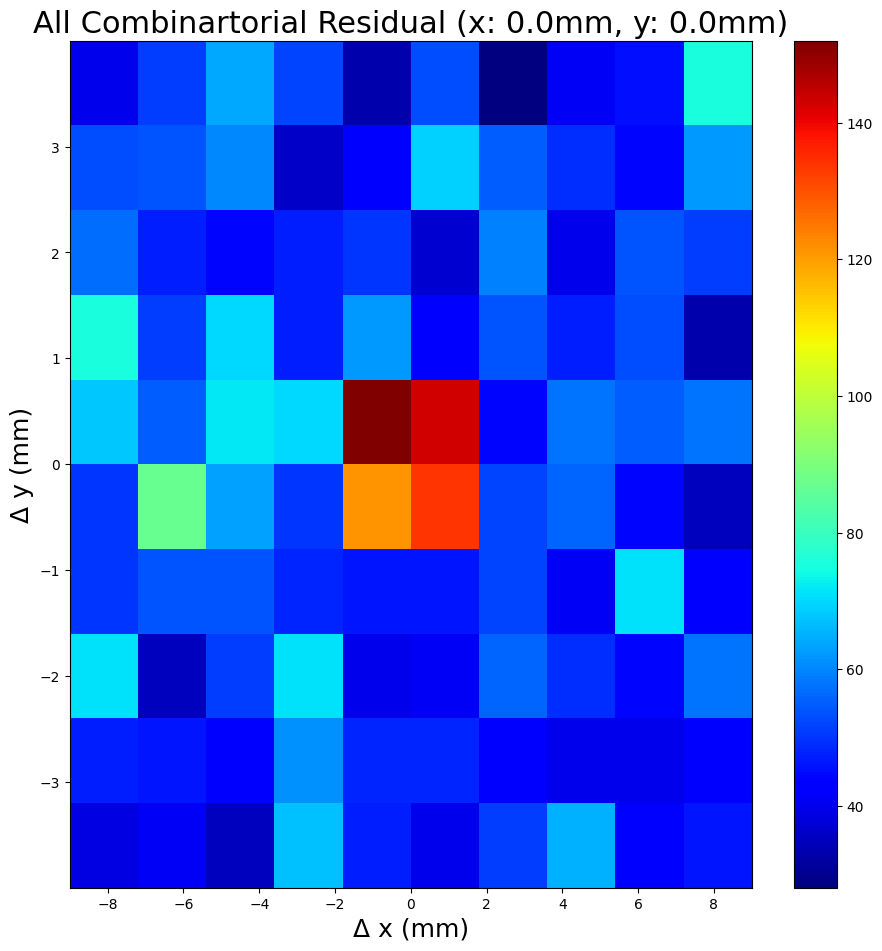

<Figure size 640x480 with 0 Axes>

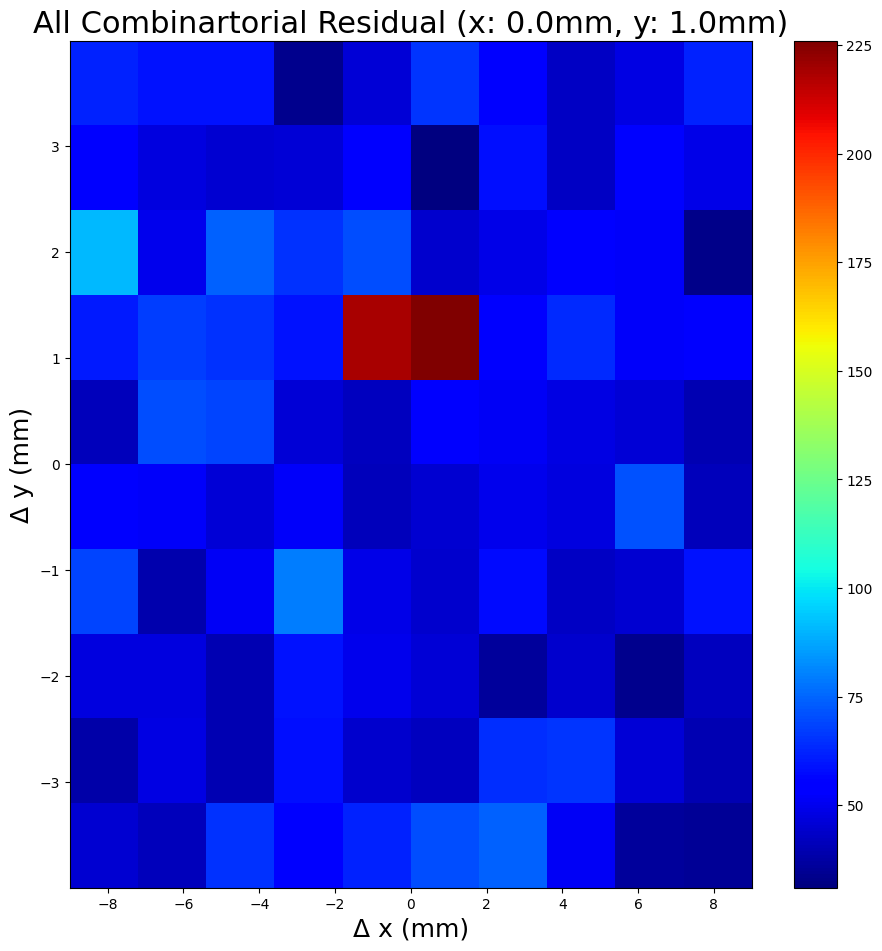

<Figure size 640x480 with 0 Axes>

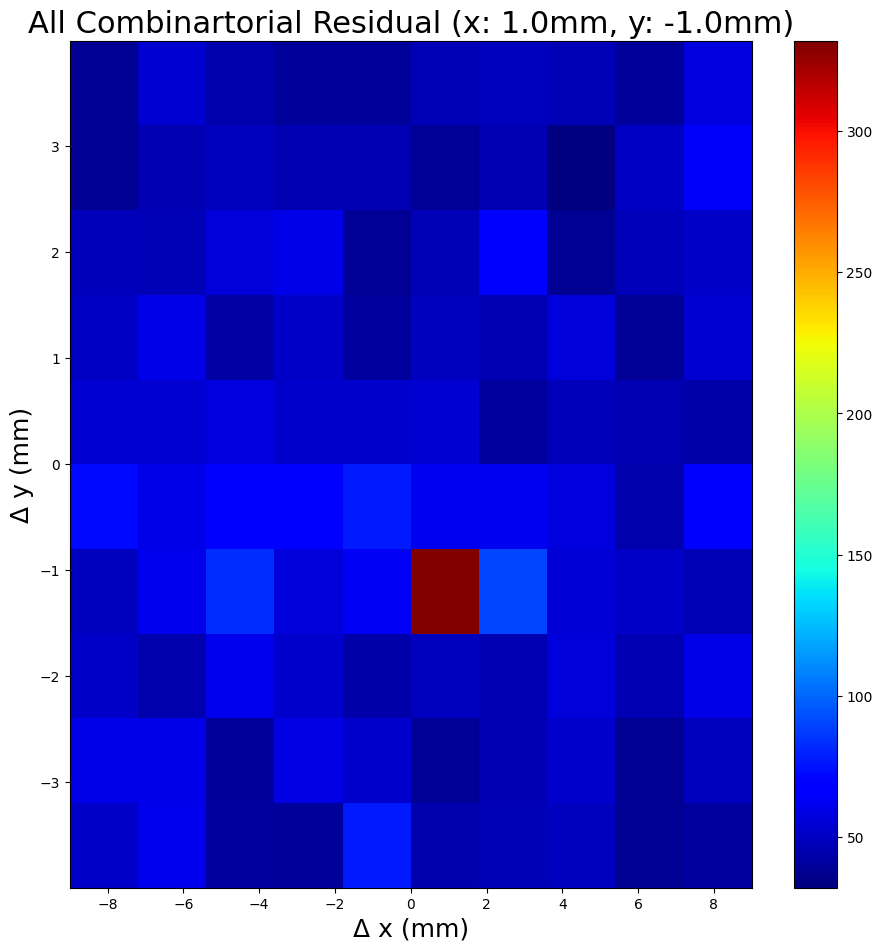

<Figure size 640x480 with 0 Axes>

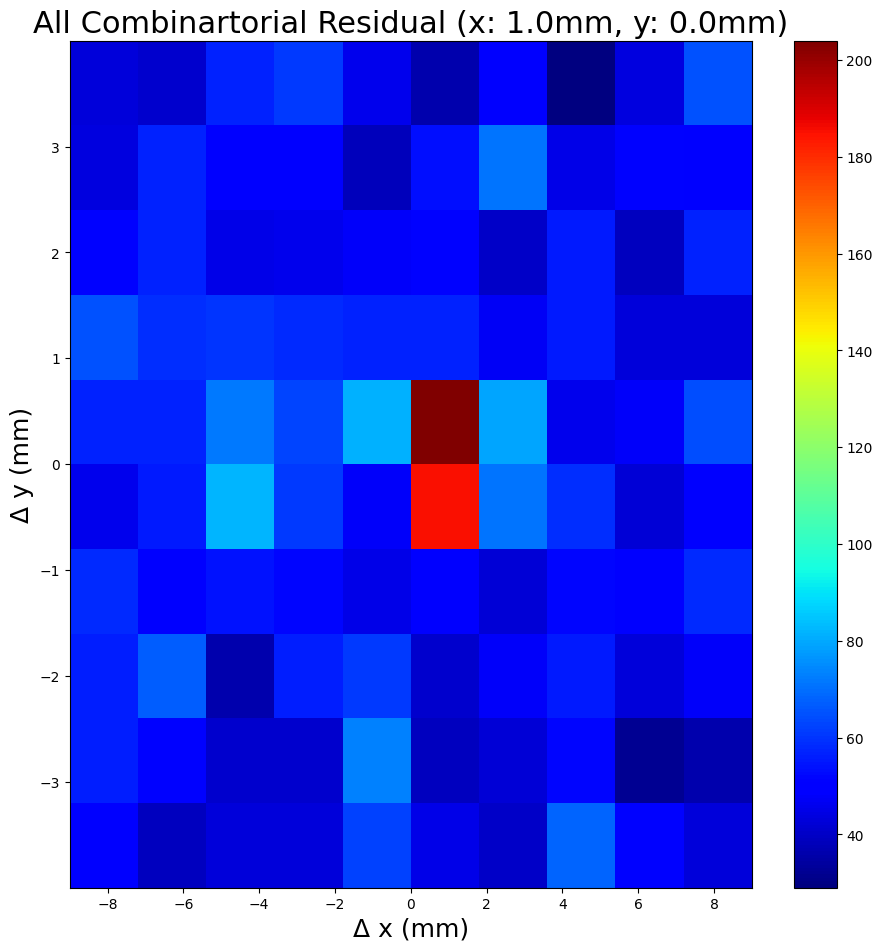

<Figure size 640x480 with 0 Axes>

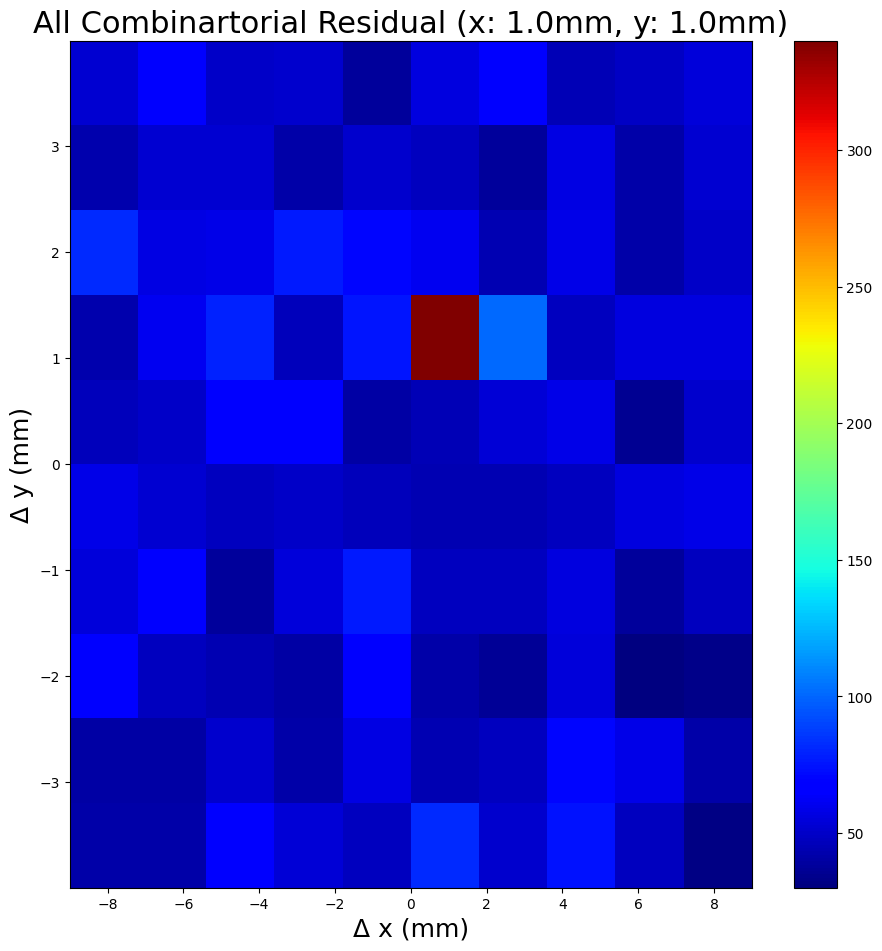

<Figure size 640x480 with 0 Axes>

In [ ]:
# Density Plot
dx, dy = np.linspace(-1, 1, 3), np.linspace(-1, 1, 3)
for i in range(len(dx)):
    for j in range(len(dy)):
        dy_tmp = ((np.array(ift_y_pred) + dy[j]).reshape(len(ift_x_pred), 1) - np.array(emu.y_pred)).flatten()
        dx_tmp = ((np.array(ift_x_pred) + dx[i]).reshape(len(ift_x_pred), 1) - np.array(emu.x_pred)).flatten()
        dtx_tmp = ((np.array(ifttx)).reshape(len(ift_x_pred), 1) - np.array(emu['tx'])).flatten()
        dty_tmp = ((np.array(iftty)).reshape(len(ift_x_pred), 1) - np.array(emu['ty'])).flatten()
        
        m = pd.DataFrame({'x_res': dx_tmp, 'y_res': dy_tmp, 'tx_res': dtx_tmp, 'ty_res': dty_tmp})
        m = m[(abs(m['x_res']) < 9) & (abs(m['y_res']) < 4)] # Can add ty cut to further increase the performance

        plt.figure(figsize=(11, 11)) 
        dy_sel = m['y_res']
        dx_sel = m['x_res']
        plt.hist2d(dx_sel, dy_sel, bins=(10, 10), cmap=plt.cm.jet)
        plt.xlabel(f'Δ x (mm)', fontsize=18)
        plt.ylabel(f'Δ y (mm)', fontsize=18)
        plt.title(f'All Combinartorial Residual (x: {round(dx[i], 2)}mm, y: {round(dy[j], 2)}mm)', fontsize=22)
        #plt.xticks(np.linspace(-9, 9, 11), fontsize=10)
        #plt.yticks(np.linspace(-.2, .2, 11), fontsize=10)
        plt.colorbar()

        plt.show()
        plt.clf()

# Minimum Chi2 Matching

In [ ]:
x_res, y_res, tx_res, ty_res = 1.7211, 0.1811, 0.01406, 0.00295 # obtain these from truth match residual
def Chi2Match(chi2cut):
    Chi2 = []
    resx, resy, restx, resty = [], [], [], []
    sus = []
    for i in range(len(ift_x_pred)):
    #for i in range(1):
        emu_filter = emu[(emu.x_pred > ift_x_pred[i]-3*x_res/2) & (emu.x_pred < ift_x_pred[i]+3*x_res/2) & (emu.y_pred > ift_y_pred[i]-3*y_res/2) & (emu.y_pred < ift_y_pred[i]+3*y_res/2)]
        chi2 = np.sqrt((ift_x_pred[i]-emu_filter.x_pred)**2/(1.7211)**2 + (ift_y_pred[i]-emu_filter.y_pred)**2/(0.01811)**2 + (ifttx[i]-emu_filter.tx)**2/(0.01406)**2 + (iftty[i]-emu_filter.ty)**2/(0.00295)**2)
        
        if np.min(chi2) < chi2cut: 
            min_num = np.where(chi2==np.min(chi2))[0][0]
            resx.append(ift_x_pred[i] - emu_filter.x_pred.iloc[min_num])
            resy.append(ift_y_pred[i] - emu_filter.y_pred.iloc[min_num])
            restx.append(ifttx[i] - emu_filter.tx.iloc[min_num])
            resty.append(iftty[i] - emu_filter.ty.iloc[min_num])

            if ift_evt[i] == emu_filter.eventID.iloc[min_num]: # Mark success if the event ID is matched
                sus.append(1)
            else: 
                sus.append(0)
    return sus

sus = Chi2Match(20) # choose 20 as the mininum chi2 cut
sus_count = collections.Counter(sus)

print(f'Successfully matched percent {sus_count[1]/(sus_count[0]+sus_count[1]):.3e} %')

Successfully matched percent 9.407e-01 %


## Study of optimal minimum chi2 cut value

In [ ]:
x_res, y_res, tx_res, ty_res = 1.7211, 0.1811, 0.01406, 0.00295
def long(chi2cut):
    Chi2 = []
    resx, resy, restx, resty = [], [], [], []
    sus = []
    for i in range(len(ift_x_pred)):
    #for i in range(1):
        emu_filter = emu[(emu.x_pred > ift_x_pred[i]-3*x_res/2) & (emu.x_pred < ift_x_pred[i]+3*x_res/2) & (emu.y_pred > ift_y_pred[i]-3*y_res/2) & (emu.y_pred < ift_y_pred[i]+3*y_res/2)]
        chi2 = np.sqrt((ift_x_pred[i]-emu_filter.x_pred)**2/(1.7211)**2 + (ift_y_pred[i]-emu_filter.y_pred)**2/(0.01811)**2 + (ifttx[i]-emu_filter.tx)**2/(0.01406)**2 + (iftty[i]-emu_filter.ty)**2/(0.00295)**2)
        
        if np.min(chi2) < chi2cut: 
            min_num = np.where(chi2==np.min(chi2))[0][0]
            resx.append(ift_x_pred[i] - emu_filter.x_pred.iloc[min_num])
            resy.append(ift_y_pred[i] - emu_filter.y_pred.iloc[min_num])
            restx.append(ifttx[i] - emu_filter.tx.iloc[min_num])
            resty.append(iftty[i] - emu_filter.ty.iloc[min_num])

            if ift_evt[i] == emu_filter.eventID.iloc[min_num]:
                sus.append(1)
            else: 
                sus.append(0)
        

    co = collections.Counter(sus)
    tmp.append(co[1]/(co[0]+co[1]))
    tm.append(co[1])
    mm.append(co[0])

tmp = []
tm, mm = [], []
for i in tqdm(np.linspace(1, 40, 40)):
    long(i)

100%|██████████| 40/40 [02:06<00:00,  3.15s/it]


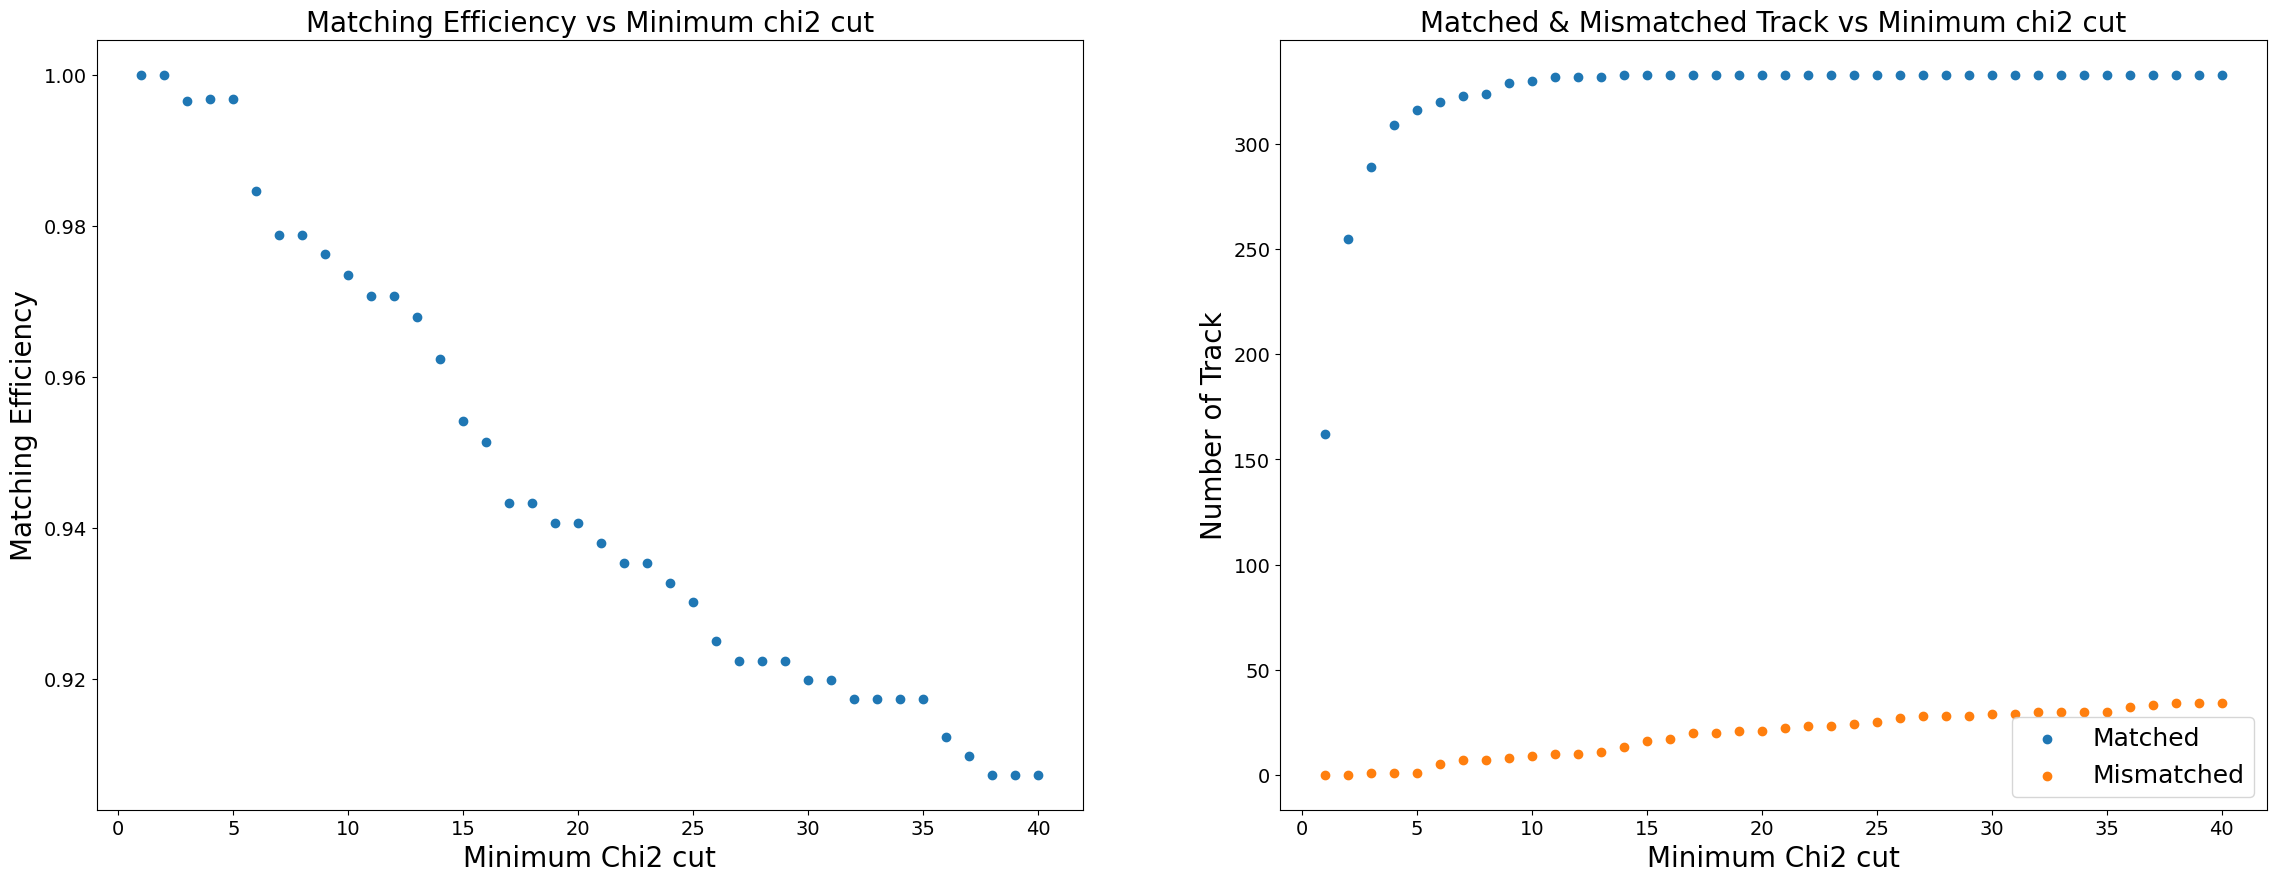

In [ ]:
plt.figure(figsize=(28, 10))
plt.subplot(1, 2, 1)
c2 = np.linspace(1, 40, 40)
plt.scatter(c2, tmp)
plt.ylabel('Matching Efficiency', fontsize=20)
plt.xlabel('Minimum Chi2 cut', fontsize=20)
plt.title('Matching Efficiency vs Minimum chi2 cut', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.subplot(1, 2, 2)
plt.scatter(c2, tm, label='Matched')
plt.scatter(c2, mm, label='Mismatched')
plt.ylabel('Number of Track', fontsize=20)
plt.xlabel('Minimum Chi2 cut', fontsize=20)
plt.title('Matched & Mismatched Track vs Minimum chi2 cut', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=18)